In [4]:
import os
import pandas as pd

import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri    
from rpy2.robjects.packages import importr

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from matplotlib import rc

rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

ModuleNotFoundError: No module named 'tzlocal'

In [148]:
df = pd.read_csv('cdc_state_counts.csv')
df.date = pd.to_datetime(df.date)
df['freq'] = df.outcome / df.population
df['SmoothFreq'] = df.groupby('state').freq.transform(lambda x:
                                                                x.rolling(window=2,
                                                                          win_type='gaussian',
                                                                          center=True).mean(std=2))
df['RefTime'] = df.groupby(pd.Grouper(key='date',freq='YS')
                             ).date.transform(lambda x:
                                         (x - x.min()) / dt.timedelta(days=1))

prev = df[df.date < dt.datetime(2020, 1, 1)]

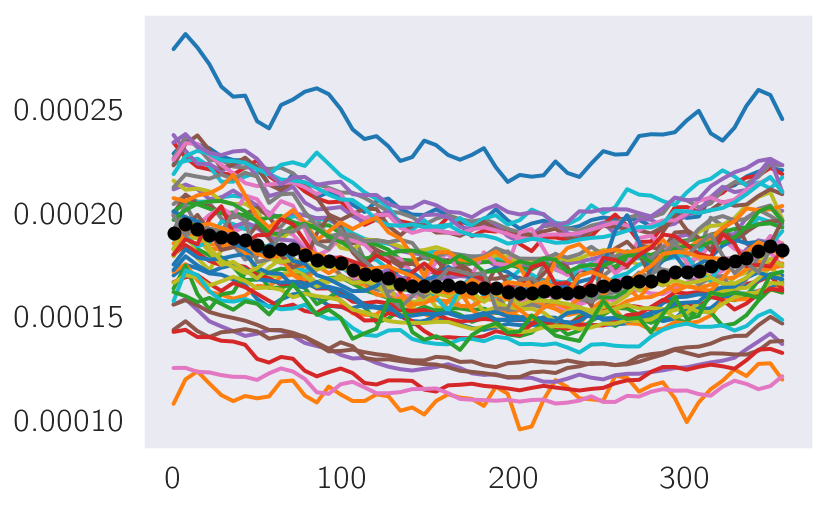

In [151]:
mean_death = prev.groupby(['state', 'RefTime']).apply(np.mean)
mean_death = mean_death[['SmoothFreq', 'outcome']]
mean_death.reset_index(inplace=True)
mean_death.head()

for n, g in mean_death.groupby('state'):
    plt.plot(g.RefTime, g.SmoothFreq)

plt.plot(mean_death.RefTime.unique(), mean_death.groupby('RefTime').SmoothFreq.apply(np.mean), 'o', color='black', zorder=np.inf)

Text(0.5, 1.0, 'Cuumulative Deaths, in Millions, per year')

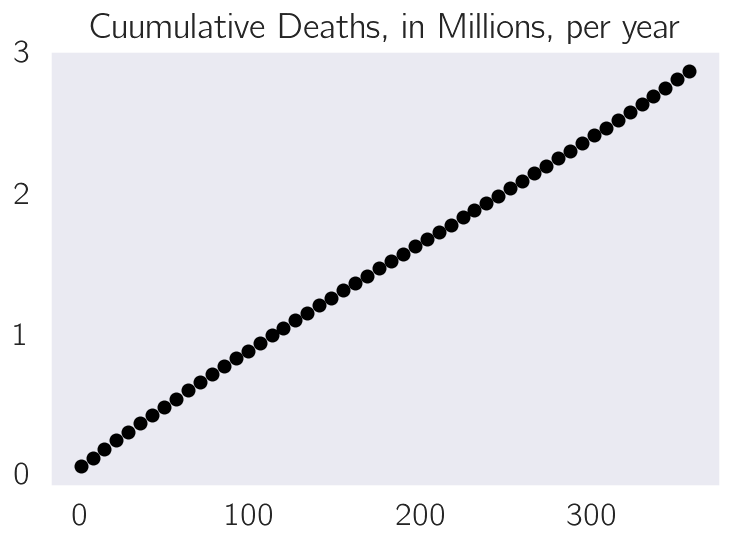

In [155]:
year_deaths = np.cumsum(mean_death.groupby('RefTime').outcome.apply(np.sum))
plt.plot(mean_death.RefTime.unique(),
         year_deaths / 10 ** 6,
         'o', color='black', zorder=np.inf)
plt.title('Cuumulative Deaths, in Millions, per year')

Text(0, 0.5, '2020 Mortality / Avg National Mortality')

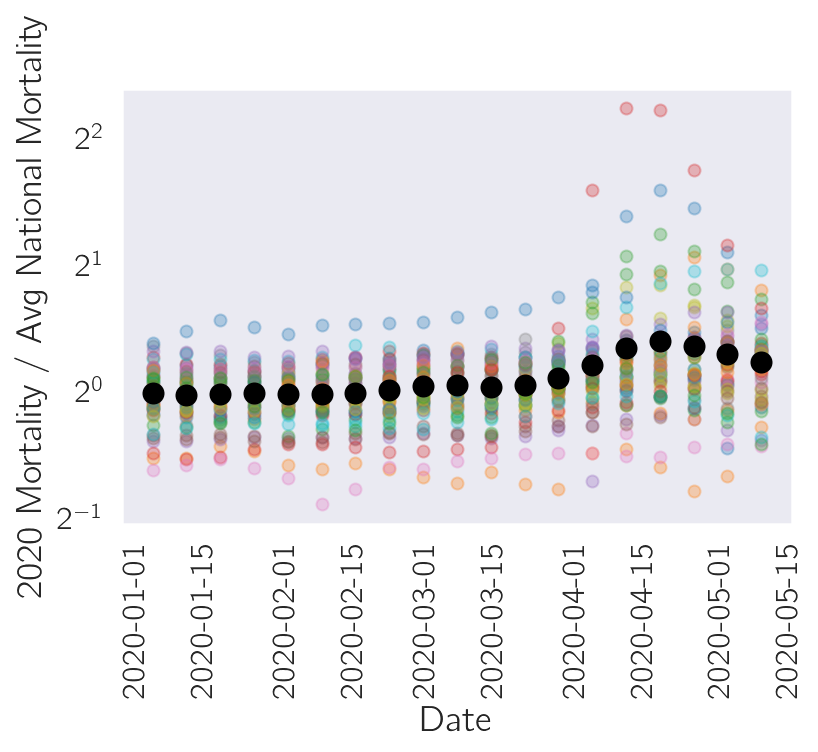

In [121]:
for n, g in df[df.date >= dt.datetime(2020, 1, 1)].groupby(['state']):
    y = g.SmoothFreq / mean_death.groupby('RefTime').SmoothFreq.apply(np.mean).values[:len(g)]
    plt.plot(g.date, y, 'o', alpha=0.3)

y = df[df.date >= dt.datetime(2020, 1, 1)].groupby('RefTime').SmoothFreq.apply(np.mean)
y = y / mean_death.groupby('RefTime').SmoothFreq.apply(np.mean).values[:len(g)]
plt.plot(df[df.date >= dt.datetime(2020, 1, 1)].date.unique(), y, 'o', color='black', zorder=np.inf, ms=10)

plt.yscale('log', basey=2)
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('2020 Mortality / Avg National Mortality')

(array([737425., 737439., 737456., 737470., 737485., 737499., 737516.,
        737530., 737546., 737560.]), <a list of 10 Text xticklabel objects>)

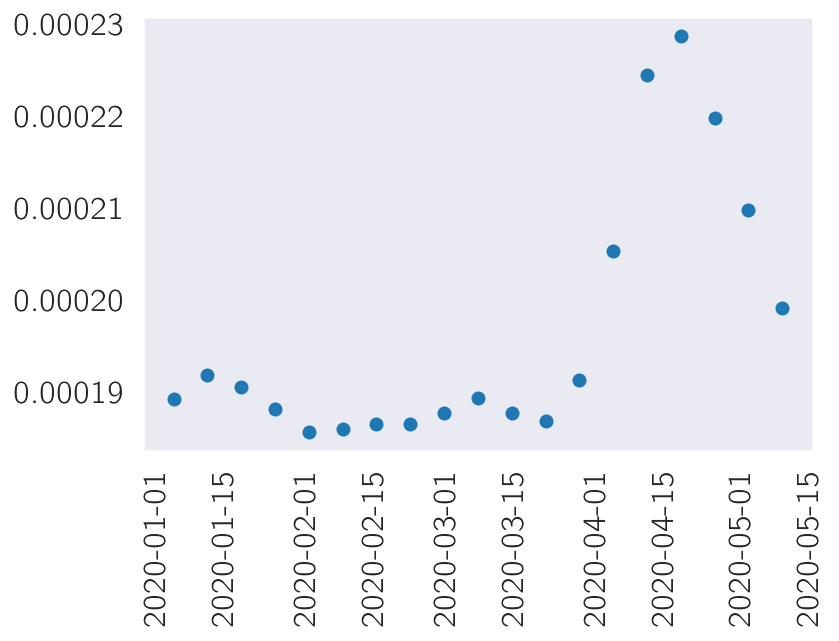

In [109]:
y = df[df.date >= dt.datetime(2020, 1, 1)].groupby('RefTime').SmoothFreq.apply(np.mean)
plt.plot(df[df.date >= dt.datetime(2020, 1, 1)].date.unique(), y, 'o')
plt.xticks(rotation=90)

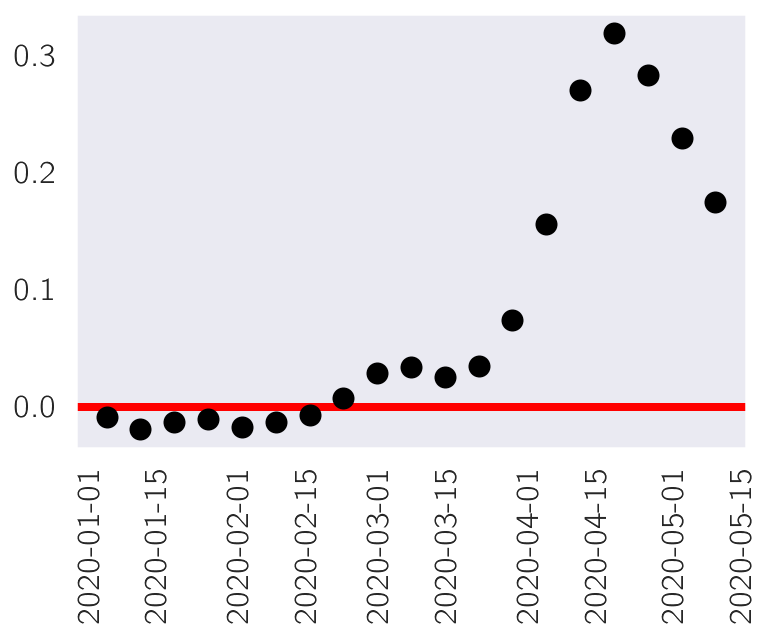

In [114]:
y = df[df.date >= dt.datetime(2020, 1, 1)].groupby('RefTime').SmoothFreq.apply(np.mean)
y = y / mean_death.groupby('RefTime').SmoothFreq.apply(np.mean).values[:len(g)]

plt.plot(df[df.date >= dt.datetime(2020, 1, 1)].date.unique(), y - 1,
         'o', color='black', zorder=np.inf, ms=10)
plt.xticks(rotation=90)
plt.axhline(0, color='red', lw=4)

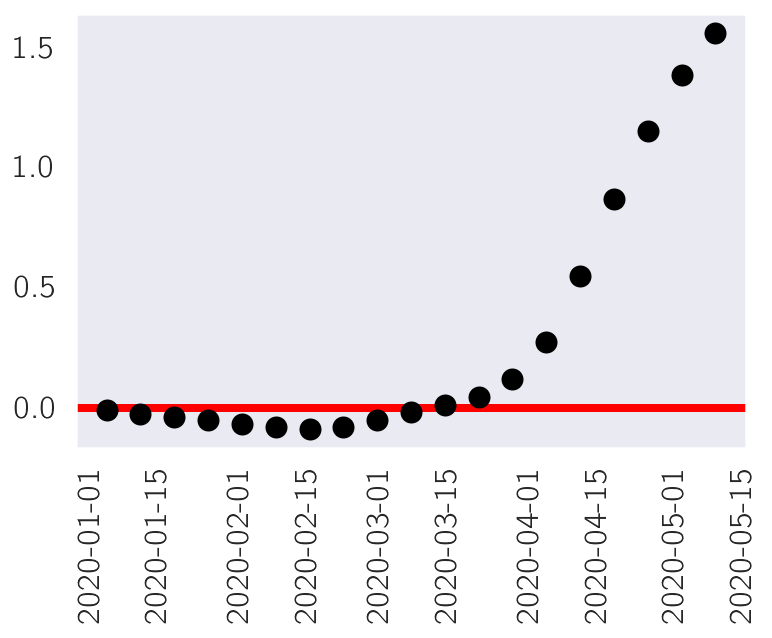

In [115]:
plt.plot(df[df.date >= dt.datetime(2020, 1, 1)].date.unique(), np.cumsum(y - 1),
         'o', color='black', zorder=np.inf, ms=10)
plt.xticks(rotation=90)
plt.axhline(0, color='red', lw=4)

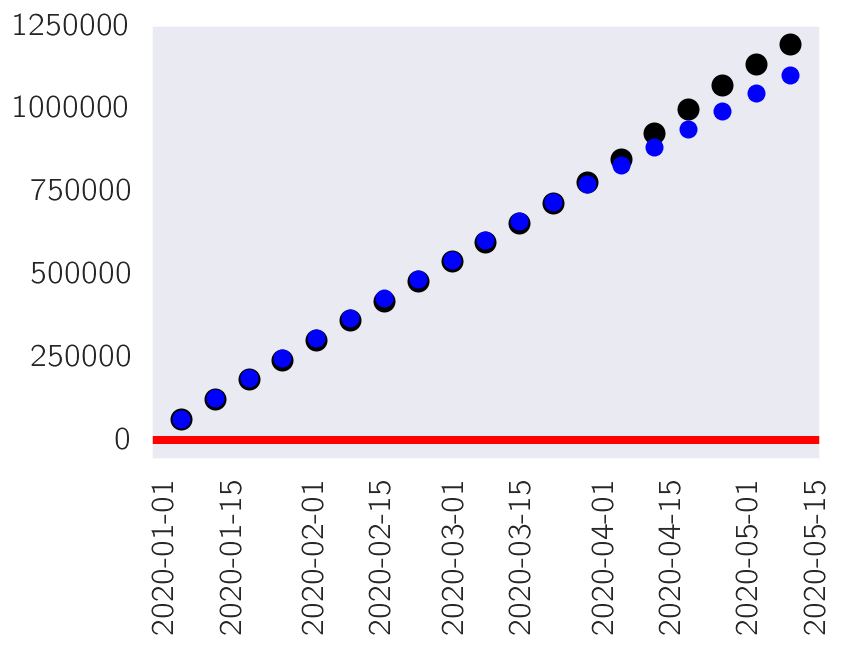

In [161]:
y = np.cumsum(df[df.date >= dt.datetime(2020, 1, 1)].groupby('date').outcome.apply(np.sum))
plt.plot(df[df.date >= dt.datetime(2020, 1, 1)].date.unique(),
         y,
         'o', color='black', zorder=np.inf, ms=10)
plt.plot(df[df.date >= dt.datetime(2020, 1, 1)].date.unique(), year_deaths.values[:len(y)],
         'o', color='blue', zorder=np.inf, ms=8)
plt.xticks(rotation=90)
plt.axhline(0, color='red', lw=4)

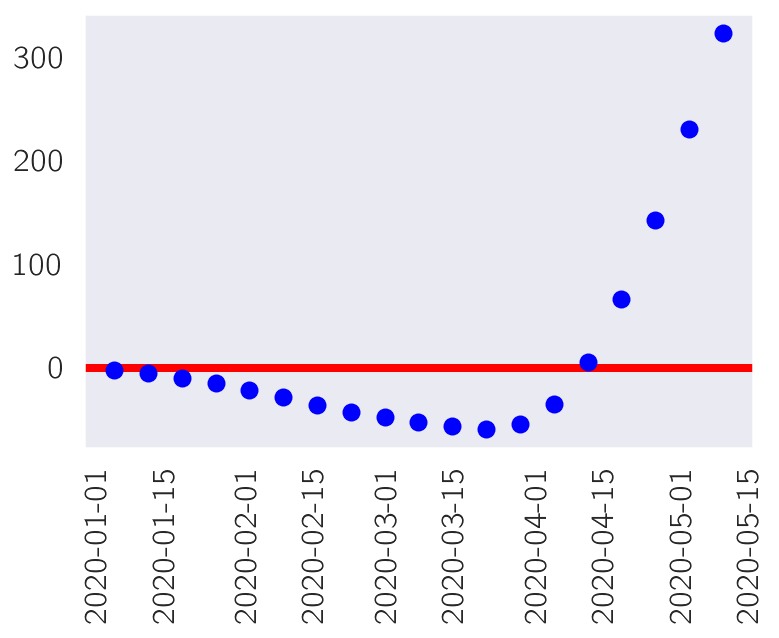

In [165]:
y = np.cumsum(df[df.date >= dt.datetime(2020, 1, 1)].groupby('date').outcome.apply(np.sum))
plt.plot(df[df.date >= dt.datetime(2020, 1, 1)].date.unique(),
         np.cumsum(y - year_deaths.values[:len(y)]) / 1000,
         'o', color='blue', zorder=np.inf, ms=8)
plt.xticks(rotation=90)
plt.axhline(0, color='red', lw=4)

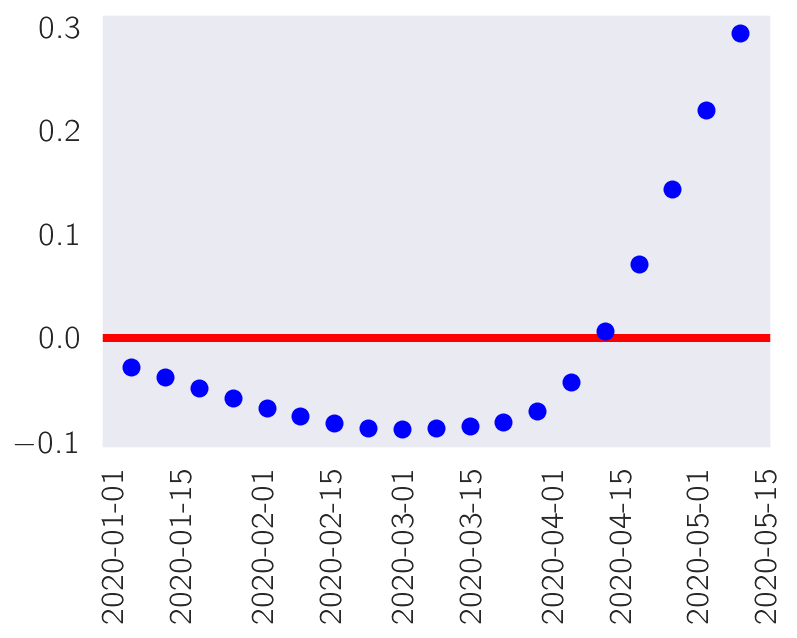

In [166]:
y = np.cumsum(df[df.date >= dt.datetime(2020, 1, 1)].groupby('date').outcome.apply(np.sum))
plt.plot(df[df.date >= dt.datetime(2020, 1, 1)].date.unique(),
         np.cumsum(y - year_deaths.values[:len(y)]) / year_deaths.values[:len(y)],
         'o', color='blue', zorder=np.inf, ms=8)
plt.xticks(rotation=90)
plt.axhline(0, color='red', lw=4)